# Inspection of WEAVE single exposures

Row-stacked spectra (RSS) of individual fibres

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import os
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.special import erf


## 2. Read data

### Ancillary data

ESO SkyCalc <http://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC>

In [2]:
wavelength_SkyCalc, intensity_SkyCalc = np.loadtxt("sky/ESO-SkyCalc_LSF.dat", unpack=True)

wavelength_SkyCalc *= 10  # nm -> Angstrom
intensity_SkyCalc *= 1e-8*(c.h*c.c/u.Angstrom).to_value(u.erg)/wavelength_SkyCalc  # ph/s/m^2/arcsec^2/micron -> erg/s/cm^2/arcsec^2/Angstrom

UVES sky emission atlas: <https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html>

In [3]:
skyline_wave, skyline_flux = np.loadtxt('sky/UVES_sky_emission_atlas/gident_580U.dat', usecols=(1, 4), unpack=True)

PS1 images:

In [4]:
def read_PS1(file_name):
    hdu = fits.open(f'SV/20230512_13/{file_name}')
    #hdu = fits.open(file_name)
    PS1_PIXEL = .25
    zero_point = 25 + 2.5*np.log10(hdu[0].header['exptime'])
    return WCS(hdu[0].header), zero_point - 2.5*np.log10(gaussian_filter(hdu[0].data, sigma=4)/PS1_PIXEL**2)

wcs_g, PS1_g = read_PS1('PS1_g.fits')
wcs_r, PS1_r = read_PS1('PS1_r.fits')
wcs_i, PS1_i = read_PS1('PS1_i.fits')
wcs_z, PS1_z = read_PS1('PS1_z.fits')

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
/tmp/ipykernel_4283/1227038250.py:6: RuntimeWarning: invalid value encountered in log10
  return WCS(hdu[0].header), zero_point - 2.5*np.log10(gaussian_filter(hdu[0].data, sigma=4)/PS1_PIXEL**2)


### WEAVE RSS files

In [5]:
# SV
work_directory = 'SV/20230512_13'
file_red = 'single_3005695.fit'
file_blue = 'single_3005696.fit'
file_red = 'single_3005697.fit'
file_blue = 'single_3005698.fit'

In [6]:
hdu_red = fits.open(os.path.join(work_directory, file_red))
hdu_blue = fits.open(os.path.join(work_directory, file_blue))

In [7]:
hdu_blue.info()

Filename: SV/20230512_13/single_3005698.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     469   ()      
  1  BLUE_DATA     1 ImageHDU        72   (4711, 600)   float32   
  2  BLUE_IVAR     1 ImageHDU        72   (4711, 600)   float32   
  3  BLUE_DATA_NOSS    1 ImageHDU        72   (4711, 600)   float32   
  4  BLUE_IVAR_NOSS    1 ImageHDU        72   (4711, 600)   float32   
  5  BLUE_SENSFUNC    1 ImageHDU        22   (4711, 600)   float32   
  6  FIBTABLE      1 BinTableHDU    181   600R x 60C   [1I, 1I, 20A, 1D, 1D, 1E, 1E, 1A, 30A, 1E, 1E, 15A, 1E, 1I, 30A, 1D, 1D, 1E, 30A, 1E, 1E, 1E, 1A, 40A, 12A, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1D, 1D, 1E, 1E, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


This is a dirty hack to fix the wavelength calibration

In [8]:
offset = 1.25  # pixels
offset = 0

In [9]:
wcs_red = WCS(hdu_red[1].header)
wavelength_red = wcs_red.spectral.pixel_to_world(offset+np.arange(hdu_red[1].data.shape[1])).to_value(u.Angstrom)
sensitivity_function_red = hdu_red[5].data
rss_red = hdu_red[1].data*sensitivity_function_red
raw_red = hdu_red[3].data

wcs_blue = WCS(hdu_blue[1].header)
wavelength_blue = wcs_blue.spectral.pixel_to_world(offset+np.arange(hdu_blue[1].data.shape[1])).to_value(u.Angstrom)
sensitivity_function_blue = hdu_blue[5].data
rss_blue = hdu_blue[1].data*sensitivity_function_blue
raw_blue = hdu_blue[3].data

### explore counts to define bright, medium, and faint regions:

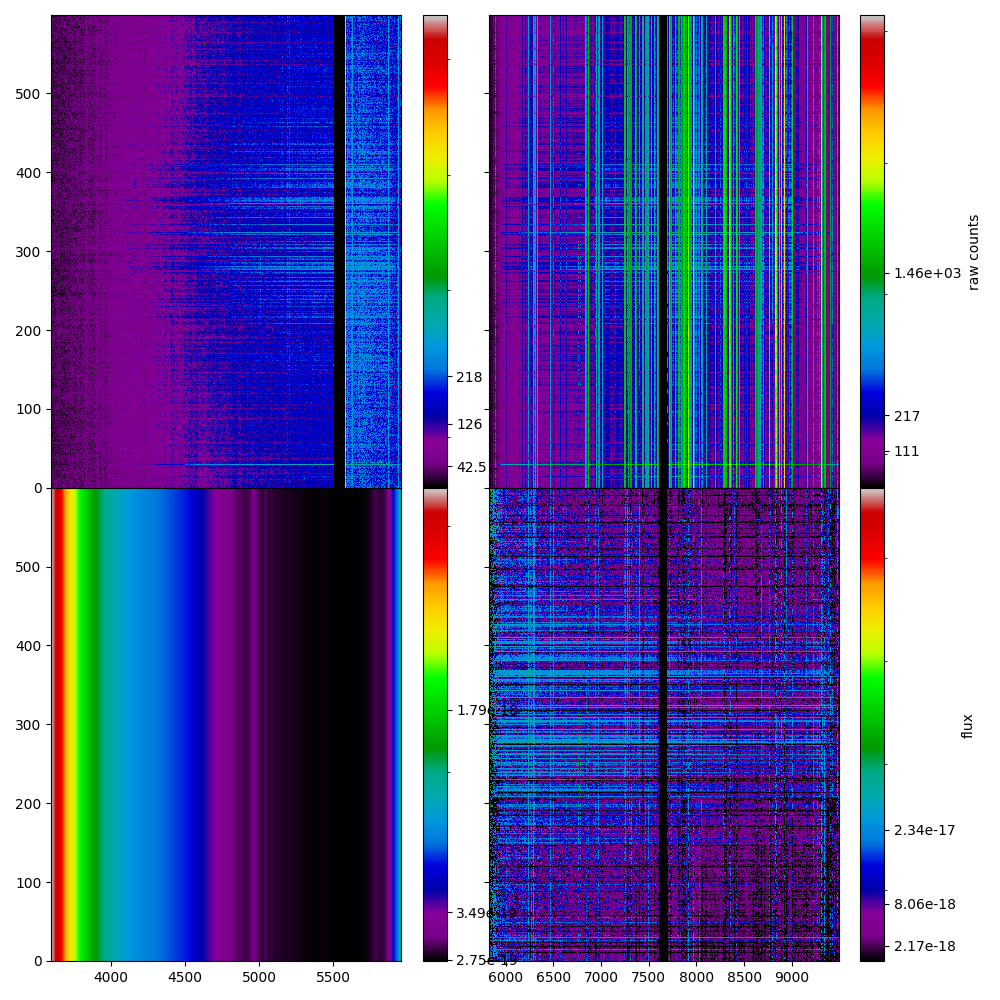

In [10]:
fig_name = 'exploration'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(10, 10))
axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)


def show_data(x, data, ax, title):
    p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
    im = ax.imshow(data,
                   extent=(x[0], x[-1], -.5, data.shape[0]-.5),
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral',
                   norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=2*p50-p0),
                  )
    ax.set_aspect('auto')
    cb = fig.colorbar(im, ax=ax, orientation='vertical')
    cb.ax.set_ylabel(title)
    cb.ax.set_yticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=0)


show_data(wavelength_blue, raw_blue, axes[0, 0], '')
show_data(wavelength_red, raw_red, axes[0, 1], 'raw counts')
show_data(wavelength_blue, sensitivity_function_blue, axes[1, 0], '')
show_data(wavelength_red, rss_red, axes[1, 1], 'flux')


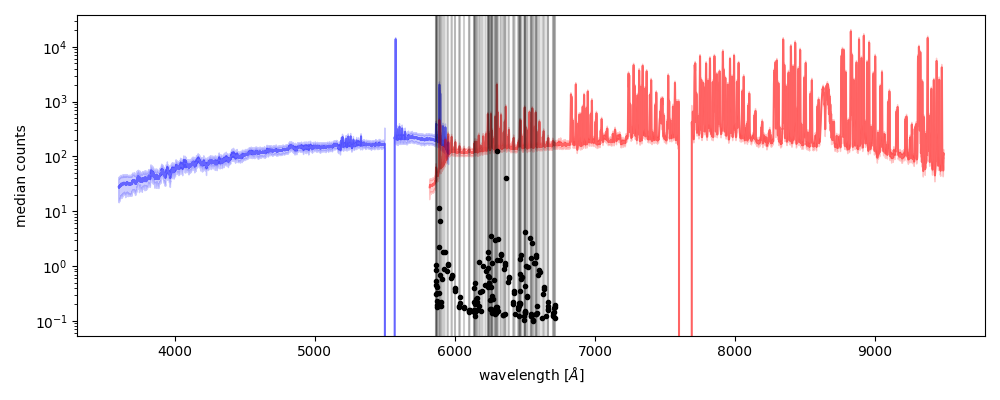

In [11]:
fig_name = 'sky_spectrum'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(10, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_ylabel('median counts')
ax.set_yscale('log')
ax.set_xlabel(r'wavelength [$\AA$]')

def find_continuum(wavelength, data, ax, color):
    p16, median = np.nanpercentile(data, [16, 50], axis=0)
    sigma = median - p16
    SN = median/(sigma + 1e-30*np.median(median[median > 0]))
    p16, p84 = np.nanpercentile(SN, [16, 84])
    continuum = np.where((SN > p16) & (SN < p84))

    ax.plot(wavelength, median, color=color, alpha=.5)
    ax.fill_between(wavelength, median-sigma, median+sigma, color=color, alpha=.2)

    #ax.plot(wavelength, SN, color=color, alpha=.2)
    #ax.axhspan(p16, p84, color=color, alpha=.2)
    
    #ax.plot(wavelength[continuum], median[continuum], color='k', alpha=.4)

    return median, sigma

ax = axes[0, 0]
sky_blue, std_sky_blue = find_continuum(wavelength_blue, raw_blue, ax, 'b')
sky_red, std_sky_red = find_continuum(wavelength_red, raw_red, ax, 'r')
ax.plot(skyline_wave, skyline_flux, 'k.')
for line in skyline_wave:
    ax.axvline(line, c='k', alpha=.1)

In [12]:
def fit_Gaussian(x, I):
    peak = np.max(I)
    background = np.min(I)
    mean_intensity = np.mean(I-background)
    mean_x = np.mean((I-background)*x)/mean_intensity
    sigma_x = np.sqrt(np.mean((I-background)*(x-mean_x)**2)/mean_intensity)

    x_min = x[np.argmin(I)]
    correction = np.exp(-.5*(x_min-mean_x)**2/sigma_x**2)
    line_flux = (peak-background)*np.sqrt(2*np.pi)*sigma_x/(1-correction)
    background = peak - line_flux/np.sqrt(2*np.pi)/sigma_x
    
    return background, line_flux, mean_x, sigma_x


/tmp/ipykernel_4283/164846032.py:20: RuntimeWarning: divide by zero encountered in true_divide
  x /= x[x.size//2]
/tmp/ipykernel_4283/164846032.py:20: RuntimeWarning: invalid value encountered in true_divide
  x /= x[x.size//2]
/tmp/ipykernel_4283/164846032.py:20: RuntimeWarning: divide by zero encountered in true_divide
  x /= x[x.size//2]
/tmp/ipykernel_4283/164846032.py:20: RuntimeWarning: invalid value encountered in true_divide
  x /= x[x.size//2]


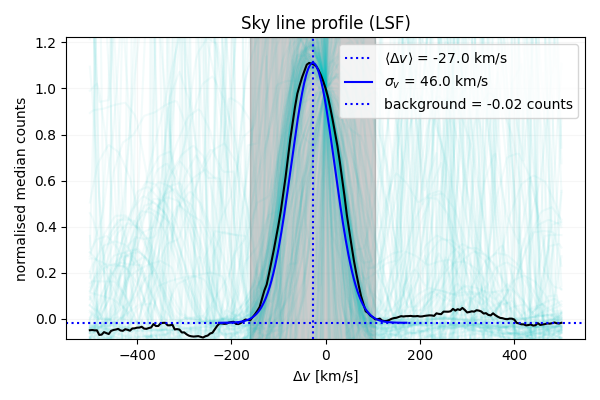

In [13]:
fig_name = 'sky_line_profiles'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(6, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_title('Sky line profile (LSF)')
ax.set_ylabel('normalised median counts')
#ax.set_yscale('log')
ax.set_xlabel(r'$\Delta v$ [km/s]')

def normalise(x):
    x -= np.nanmedian(x)
    x /= x[x.size//2]
    return x

ax = axes[0, 0]
delta_v = np.linspace(-500, 500, 201)
sky = np.nanmedian(raw_red, axis=0)
median_skyline = np.zeros((skyline_wave.size, delta_v.size))
for i, line in enumerate(skyline_wave):
    l = (1+delta_v/3e5)*line
    sed = np.interp(l, wavelength_red, sky)
    sed = normalise(sed)
    median_skyline[i] = sed
    ax.plot(delta_v, sed, 'c-', alpha=.05)

median_skyline = normalise(np.nanmedian(median_skyline, axis=0))
ax.plot(delta_v, median_skyline, 'k-')
ax.set_ylim(1.1*np.min(median_skyline), 1.1*np.max(median_skyline))

background = np.median(median_skyline)
line_left = np.max(delta_v[(delta_v < 0) & (median_skyline <= background)])
line_right = np.min(delta_v[(delta_v > 0) & (median_skyline <= background)])
ax.axvspan(line_left, line_right, color='k', alpha=.2)

narrow_profile = np.where((delta_v > line_left) & (delta_v < line_right))
delta_v = delta_v[narrow_profile]
median_skyline = median_skyline[narrow_profile]
background, line_flux, mean_v, sigma_v = fit_Gaussian(delta_v, median_skyline)

'''
mean_intensity = np.mean(median_skyline)  # continuum + int(line)/L = continuum + line_flux*flux_constant
mean_v = np.mean(median_skyline*delta_v)/mean_intensity  # line only
sigma_v = np.sqrt(np.mean(median_skyline*(delta_v-mean_v)**2)/mean_intensity)  # continuum*sigma_constant + line
peak = np.max(median_skyline)  # continuum + line_flux /sqrt(2*pi)/sigma

sigma_constant = ((line_right-mean_v)**3 - (line_left-mean_v)**3) / 3

left = (line_left-mean_v) / sigma_v
right = (line_right-mean_v) / sigma_v
flux_constant = (erf(right/np.sqrt(2)) - erf(left/np.sqrt(2))) / 2/(line_right-line_left)
line_flux = (peak-mean_intensity) / (1/np.sqrt(2*np.pi)/sigma_v - flux_constant)
bg = peak - line_flux/np.sqrt(2*np.pi)/sigma_v
print(peak, mean_intensity, line_flux, flux_constant, bg)

ax.axvline(mean_v, c='r', ls='-', label=f'$\langle\Delta v\\rangle$ = {mean_v:.1f} km/s')
x = np.linspace(line_left, line_right, delta_v.size*3)
ax.plot(x, np.max(median_skyline)*np.exp(-.5*((x-mean_v)/sigma_v)**2), 'r--', label=f'$\sigma_v$ = {sigma_v:.1f} km/s')

background = np.min(median_skyline)
delta_min = delta_v[np.argmin(median_skyline)]
correction = np.exp(-.5*(delta_min-mean_v)**2/sigma_v**2)
line_flux = (peak-background)*np.sqrt(2*np.pi)*sigma_v/(1-correction)
background = peak - line_flux/np.sqrt(2*np.pi)/sigma_v
'''

margin = (line_right-line_left)/4
x = np.linspace(line_left-margin, line_right+margin, delta_v.size*4)
ax.axvline(mean_v, c='b', ls=':', label=f'$\langle\Delta v\\rangle$ = {mean_v:.1f} km/s')
ax.plot(x, background+line_flux/np.sqrt(2*np.pi)/sigma_v*np.exp(-.5*((x-mean_v)/sigma_v)**2), 'b-', label=f'$\sigma_v$ = {sigma_v:.1f} km/s')
ax.axhline(background, c='b', ls=':', label=f'background = {background:.2f} counts')

ax.legend()

In [208]:
model = np.zeros((skyline_wave.size, 4))
model[:, 1] = skyline_flux
model[:, 2] = skyline_wave
model[:, 3] = skyline_wave*sigma_v/3e5
total_line_weight_red = np.zeros_like(wavelength_red)
background_model_red = np.zeros_like(wavelength_red)
for i in range(skyline_wave.size):
    line_profile = model[i, 1]*np.exp(-.5*((wavelength_red-model[i, 2])/model[i, 3])**2)/np.sqrt(2*np.pi)/model[i, 3]
    total_line_weight_red += line_profile
    background_model_red += model[i, 0] * line_profile

total_line_weight_red += 1e-30*np.mean(total_line_weight_red[total_line_weight_red > 0])
background_model_red /= total_line_weight_red
good = skyline_wave > 0

144
139
136
36 [5866.003906 5867.267578 5868.313477 5869.27832  5869.481934 5872.73584
 6259.189453 6261.754883 6262.74707  6262.845215 6265.223145 6268.279297
 6287.442871 6289.047852 6289.437988 6290.35498  6295.915527 6296.294922
 6297.911621 6301.281738 6308.556641 6343.240723 6361.302246 6363.782715
 6494.120117 6494.416992 6555.907227 6558.283691 6580.439941 6583.723633
 6584.487793 6620.454102 6650.8125   6714.775391 6716.733887 6717.560059]
13.795162861031582


/tmp/ipykernel_4283/4072327698.py:107: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(wavelength_red, (sky_red - background_model_red - total_line_weight_red) / std_sky_red, 'k--')


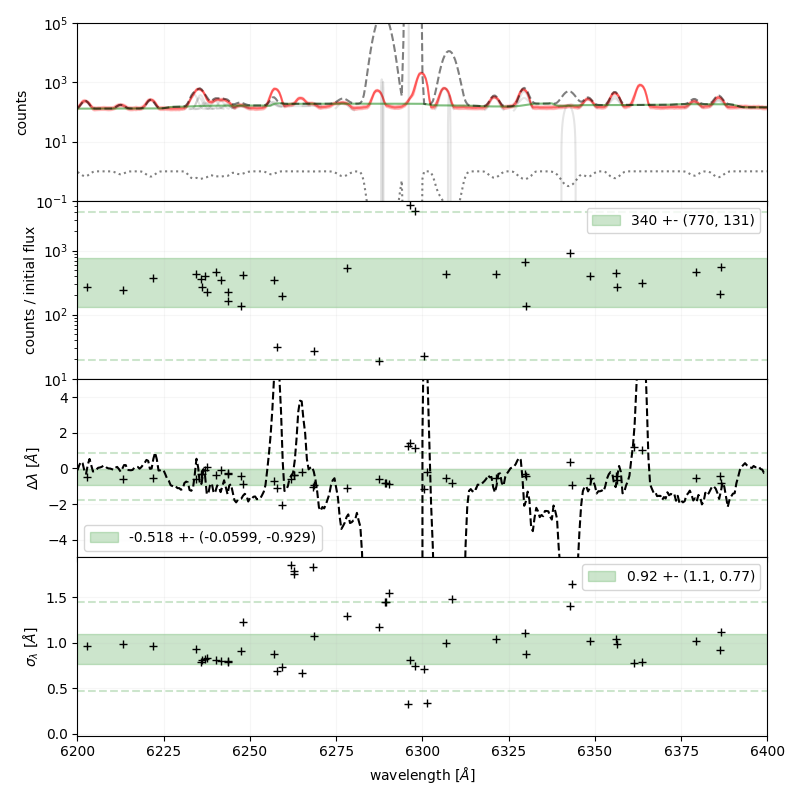

In [216]:
fig_name = 'sky_line_fit'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 8))
axes = fig.subplots(nrows=4, ncols=1, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
for ax in axes.flat:
    ax.grid(True, alpha=.1)
fig.set_tight_layout(True)

ax = axes[0, 0]
ax.set_ylabel('counts')
ax.set_yscale('log')
ax.set_ylim(.1, 1e5)

sky_blue, std_sky_blue = find_continuum(wavelength_blue, raw_blue, ax, 'b')
sky_red, std_sky_red = find_continuum(wavelength_red, raw_red, ax, 'r')

#ax.plot(wavelength_red, total_line_weight_red, 'r--', alpha=.2)
#ax.plot(wavelength_red, background_model_red, 'r--', alpha=.2)
#ax.plot(skyline_wave, skyline_flux*1e3, 'k+', alpha=.2)
#ax.plot(wavelength_red, sky_red-total_line_weight_red, 'k--', alpha=.2)
new_line_weight_red = np.zeros_like(wavelength_red)
new_background_model_red = np.zeros_like(wavelength_red)
for i, line in enumerate(skyline_wave):
    if good[i]:
        lam = (1+delta_v/3e5)*line
        sky = np.interp(lam, wavelength_red, (sky_red-background_model_red)/total_line_weight_red)
        sky *= model[i, 1]*np.exp(-.5*((lam-model[i, 2])/model[i, 3])**2)/np.sqrt(2*np.pi)/model[i, 3]

        #background, line_flux, mean_wavelength, sigma_wavelength = fit_Gaussian(lam, sky)
        #print(np.min(sky), background, line_flux, mean_wavelength, sigma_wavelength)

        #ax.axvspan(lam[0], lam[-1], color='k', alpha=.1)
        #ax.axvline(line, c='k', ls='-', alpha=.1)
        model[i] = fit_Gaussian(lam, sky)
        line_profile = model[i, 1]*np.exp(-.5*((wavelength_red-model[i, 2])/model[i, 3])**2)/np.sqrt(2*np.pi)/model[i, 3]
        new_line_weight_red += line_profile
        model[i, 0] += np.interp(model[i, 2], wavelength_red, background_model_red)
        new_background_model_red += max(model[i, 0], 0) * line_profile
        ax.plot(lam,
                model[i, 0] + model[i, 1]*np.exp(-.5*((lam-model[i, 2])/model[i, 3])**2)/np.sqrt(2*np.pi)/model[i, 3],
                'k-', alpha=.1)

new_line_weight_red += np.min(new_line_weight_red[new_line_weight_red > 0])

total_line_weight_red = new_line_weight_red
total_line_weight_red += 1e-30*np.mean(total_line_weight_red[total_line_weight_red > 0])
w = sky_red/(sky_red+total_line_weight_red)
background_model_red = w*(sky_red-total_line_weight_red) +(1-w)*new_background_model_red/total_line_weight_red
integral_model = np.cumsum(background_model_red*w)
integral_w = np.cumsum(w)
w_smooth = delta_v.size
w0 = (integral_w - w_smooth).clip(min=integral_w[0])
w1 = (integral_w + w_smooth).clip(max=integral_w[-1])
background_model_red = (np.interp(w1, integral_w, integral_model) - np.interp(w0, integral_w, integral_model)) / (w1 - w0)
ax.plot(wavelength_red, background_model_red, 'g-', alpha=.5)
ax.plot(wavelength_red, background_model_red+total_line_weight_red, 'k--', alpha=.5)
#ax.plot(wavelength_red, total_line_weight_red, 'b-', alpha=.2)
#ax.plot(wavelength_red, sky_red-total_line_weight_red, 'k-', alpha=.7)
#ax.plot(model[:, 2], model[:, 1], 'g.', alpha=.2)
ax.plot(wavelength_red, w, 'k:', alpha=.5)


ax = axes[1, 0]
ax.set_ylabel('counts / initial flux')
ax.set_yscale('log')

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 1]/skyline_flux[i], 'k+')

y = model[:, 1]/skyline_flux
p16, p50, p84 = np.percentile(y, [16, 50, 84])
y_min = p50*(p16/p50)**3
y_max = p50*(p84/p50)**3
good = (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
ax.set_ylim(.5*y_min, 1.5*y_max)
print(np.count_nonzero(good))


ax = axes[2, 0]
ax.set_ylabel(r'$\Delta\lambda$ [$\AA$]')
#ax.set_yscale('log')
#ax.set_ylim(-100, 100)

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 2]-line, 'k+')

y = model[:, 2]-skyline_wave
p16, p50, p84 = np.percentile(y, [16, 50, 84])
y_min = p50 - 3*(p50-p16)
y_max = p50 + 3*(p84-p50)
good &= (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
margin = .5*(y_max-y_min)
#ax.set_ylim(y_min-margin, y_max+margin)
ax.set_ylim(-5, 5)
print(np.count_nonzero(good))
ax.plot(wavelength_red, (sky_red - background_model_red - total_line_weight_red) / std_sky_red, 'k--')


ax = axes[3, 0]
ax.set_ylabel(r'$\sigma_\lambda$ [$\AA$]')
#ax.set_yscale('log')
#ax.set_ylim(-100, 100)

for i, line in enumerate(skyline_wave):
    ax.plot(line, model[i, 3], 'k+')

y = model[:, 3]
p16, p50, p84 = np.percentile(y, [16, 50, 84])
y_min = p50 - 3*(p50-p16)
y_max = p50 + 3*(p84-p50)
good &= (y > y_min) & (y < y_max)
ax.axhspan(p16, p84, label=f'{p50:.3g} +- ({p84:.3g}, {p16:.3g})', color='green', alpha=.2)
ax.axhline(y_max, color='green', alpha=.2, ls='--')
ax.axhline(y_min, color='green', alpha=.2, ls='--')
ax.legend()
margin = .5*(y_max-y_min)
ax.set_ylim(y_min-margin, y_max+margin)
print(np.count_nonzero(good))

ax = axes[-1, 0]
ax.set_xlabel(r'wavelength [$\AA$]')
ax.set_xlim(6200, 6400)
#ax.set_xlim(6500, 6600)
#ax.set_xlim(5800, 5900)

print(np.count_nonzero(~good), skyline_wave[~good])
std_sky_red += 1e-30*np.mean(std_sky_red[std_sky_red > 0])
print(np.median(((sky_red - background_model_red - total_line_weight_red) /std_sky_red)**2))


In [69]:
delta_v.size

52

In [ ]:
mean_counts_red = np.nanmean(hdu_red[1].data, axis=0)  # same as hdu[6]
mean_sky_map_red = np.nanmean(hdu_red[3].data-hdu_red[1].data, axis=0)

mask_bright = mean_counts_red > mean_sky_map_red
mask_faint = (mean_counts_red > 0) & (mean_counts_red <= mean_sky_map_red)
mask_all = mean_counts_red > 0

In [ ]:
plt.close('counts')
fig = plt.figure('counts', figsize=(6, 4))
ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                  sharex=True, sharey=True,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)


def show_data(data, ax, title):
    p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral',
                   norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                  )
    ax.contour(mask_faint, levels=[0.5], colors=['w'])
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_title(title)
    cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)

show_data(mean_counts_red, ax[0, 0], 'Mean counts')
show_data(mean_sky_map_red, ax[0, 1], 'Mean sky')

plt.show()

### broadband colors:

In [ ]:
class Filter(object):
    
    def __init__(self, filename, col_wavelength=0, col_response=1):
        self.wavelength, self.response = np.loadtxt(filename, usecols=(col_wavelength, col_response), unpack=True)        
        #self.norm_AB =  np.trapz(3631/3.34e4 * self.response/self.wavelength, self.wavelength)
        self.pivot_wavelength =  np.sqrt(
            np.trapz(self.response, self.wavelength) / np.trapz(self.response/self.wavelength**2, self.wavelength))
        
    def m_AB(self, wavelength, F_lambda):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(wavelength*F_lambda*response, wavelength) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

    def m_AB_cube(self, wavelength, F_lambda_cube):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(F_lambda_cube*(wavelength*response)[:, np.newaxis, np.newaxis], wavelength, axis=0) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

g_filter = Filter('sdss-filters/g.dat', 0, 2)
r_filter = Filter('sdss-filters/r.dat', 0, 2)
i_filter = Filter('sdss-filters/i.dat', 0, 2)
z_filter = Filter('sdss-filters/z.dat', 0, 2)

### average SED within each region and broadband maps:

In [ ]:
datacube = (hdu_red[3].data - hdu_red[1].data) * sensitivity_function_red[:, np.newaxis, np.newaxis]
sky_red = np.sum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)
datacube = (hdu_blue[3].data - hdu_blue[1].data) * sensitivity_function_blue[:, np.newaxis, np.newaxis]
sky_blue = np.sum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)


In [ ]:
LIFU_FIBRE_RADIUS = 1.305  # arcsec (2.6 arcsec diameter)
LIFU_FIBRE_AREA = np.pi*LIFU_FIBRE_RADIUS**2
datacube = hdu_red[1].data * sensitivity_function_red[:, np.newaxis, np.newaxis] / LIFU_FIBRE_AREA
SED_bright_red = np.sum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_faint_red = np.sum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
r_map = r_filter.m_AB_cube(wavelength_red, datacube)
i_map = i_filter.m_AB_cube(wavelength_red, datacube)
z_map = z_filter.m_AB_cube(wavelength_red, datacube)

In [ ]:
datacube = hdu_blue[1].data * sensitivity_function_blue[:, np.newaxis, np.newaxis] / LIFU_FIBRE_AREA
SED_bright_blue = np.sum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_faint_blue = np.sum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
g_map = g_filter.m_AB_cube(wavelength_blue, datacube)


In [ ]:
def show_data(data, ax, title, cmap, vmin, vmax, projection):
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap=cmap, vmin=vmin, vmax=vmax,
                  )
    ax.contour(mask_bright, levels=[0.5], colors=['w'])
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_title(title)
    #cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)


In [ ]:
fig_name = 'broadband_SED'
plt.close(fig_name)
nrows = 2
ncols = 4.1
margin1 = .1
margin2 = .05
L = 1-margin2-margin1
dx = L/ncols
dy = L/nrows
panel_size = 3
fig = plt.figure(fig_name, figsize=(panel_size*ncols, panel_size*nrows))

def init_axis(x, y, wcs):
    ax = fig.add_axes([margin1+x*dx, margin1+y*dy, dx, dy], projection=wcs,
                      sharex=ax0, sharey=ax0
                     )
    ax. grid(True, alpha=.5)
    if(y > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[0].set_ticklabel_visible(False)
    if(x > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    return ax


y = 1
mag_min = 17
mag_max = 25

ax0 = fig.add_axes([margin1, margin1+y*dy, dx, dy], projection=wcs_blue.celestial)
ax = ax0
ax. grid(True, alpha=.5)
im = ax.imshow(g_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(1, y, wcs_red.celestial)
im = ax.imshow(r_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(2, y, wcs_red.celestial)
im = ax.imshow(i_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(3, y, wcs_red.celestial)
im = ax.imshow(z_map,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')
ax.set_ylim(mag_max, mag_min)

y = 0
color_min = -.1
color_max = 1.1

ax = init_axis(0, y, wcs_red.celestial)
im = ax.imshow(g_map-r_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(1, y, wcs_red.celestial)
im = ax.imshow(r_map-i_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(2, y, wcs_red.celestial)
im = ax.imshow(i_map-z_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(3, y, wcs_red.celestial)
im = ax.imshow(r_map-z_map,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


plt.tight_layout()

In [ ]:
fig_name = 'broadband_PS1'
plt.close(fig_name)
nrows = 2
ncols = 4.1
margin1 = .1
margin2 = .05
L = 1-margin2-margin1
dx = L/ncols
dy = L/nrows
panel_size = 3
fig = plt.figure(fig_name, figsize=(panel_size*ncols, panel_size*nrows))

xmin, xmax = ax0.get_xlim()
ymin, ymax = ax0.get_ylim()
print(xmin, xmax, ymin, ymax)
bottom_left = wcs_red.celestial.pixel_to_world(xmin, ymin)
top_right = wcs_red.celestial.pixel_to_world(xmax, ymax)
print(bottom_left.ra, top_right.ra, bottom_left.dec, top_right.dec)
xmin, ymin = wcs_r.world_to_pixel_values(bottom_left.ra, bottom_left.dec)
xmax, ymax = wcs_r.world_to_pixel_values(top_right.ra, top_right.dec)
print(xmin, xmax, ymin, ymax)

def init_axis(x, y, wcs):
    ax = fig.add_axes([margin1+x*dx, margin1+y*dy, dx, dy], projection=wcs,
                      sharex=ax1, sharey=ax1
                     )
    ax. grid(True, alpha=.5)
    if(y > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[0].set_ticklabel_visible(False)
    if(x > 0):
        ax.coords[0].set_auto_axislabel(False)
        ax.coords[1].set_auto_axislabel(False)
        ax.coords[1].set_ticklabel_visible(False)
    #ax.set_xlabel(' ')
    #ax.set_ylabel(' ')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return ax


y = 1
#mag_min = 15.5
#mag_max = 25.5

ax1 = fig.add_axes([margin1, margin1+y*dy, dx, dy], projection=wcs_g)
ax = ax1
ax. grid(True, alpha=.5)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
im = ax.imshow(PS1_g,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(1, y, wcs_r)
im = ax.imshow(PS1_r,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(2, y, wcs_i)
im = ax.imshow(PS1_i,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = init_axis(3, y, wcs_z)
im = ax.imshow(PS1_z,
               interpolation='nearest', origin='lower',
               cmap='nipy_spectral_r', vmin=mag_min, vmax=mag_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


y = 0
#color_min = .1
#color_max = .9

ax = init_axis(0, y, wcs_r)
im = ax.imshow(PS1_g-PS1_r,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(1, y, wcs_r)
im = ax.imshow(PS1_r-PS1_i,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(2, y, wcs_r)
im = ax.imshow(PS1_i-PS1_z,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = init_axis(3, y, wcs_r)
im = ax.imshow(PS1_r-PS1_z,
               interpolation='nearest', origin='lower',
               cmap='rainbow', vmin=color_min, vmax=color_max,
              )
ax = fig.add_axes([margin1+4*dx, margin1+y*dy, .1*dx, dy])
cb = fig.colorbar(im, cax=ax, orientation='vertical')


plt.tight_layout()

## 3. Spectrophotometric calibration:
### Compute correction:

In [ ]:

def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

wavelength_blue_continuum, sky_blue_continuum = find_continuum(wavelength_blue, sky_blue, 3);
wavelength_red_continuum, sky_red_continuum = find_continuum(wavelength_red, sky_red, 3);
wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum = find_continuum(wavelength_SkyCalc, intensity_SkyCalc, 2);
correction_blue = intensity_SkyCalc_continuum / np.interp(wavelength_SkyCalc_continuum, wavelength_blue_continuum, sky_blue_continuum)
correction_blue = np.interp(wavelength_blue, wavelength_SkyCalc_continuum, correction_blue)
correction_blue /= np.median(correction_blue)
correction_red = intensity_SkyCalc_continuum / np.interp(wavelength_SkyCalc_continuum, wavelength_red_continuum, sky_red_continuum)
correction_red = np.interp(wavelength_red, wavelength_SkyCalc_continuum, correction_red)
correction_red /= np.median(correction_red)


In [ ]:
g_bright = g_filter.m_AB(wavelength_blue, SED_bright_blue)
r_bright = r_filter.m_AB(wavelength_red, SED_bright_red)
i_bright = i_filter.m_AB(wavelength_red, SED_bright_red)
z_bright = z_filter.m_AB(wavelength_red, SED_bright_red)
g_faint = g_filter.m_AB(wavelength_blue, SED_faint_blue)
r_faint = r_filter.m_AB(wavelength_red, SED_faint_red)
i_faint = i_filter.m_AB(wavelength_red, SED_faint_red)
z_faint = z_filter.m_AB(wavelength_red, SED_faint_red)
g_sky = g_filter.m_AB(wavelength_blue, sky_blue)
r_sky = r_filter.m_AB(wavelength_red, sky_red)
i_sky = i_filter.m_AB(wavelength_red, sky_red)
z_sky = z_filter.m_AB(wavelength_red, sky_red)


In [ ]:
lines = {}
lines['OII_3726'] = [3726.032, 3717.0, 3737.0]
lines['OII_3729'] = [3728.815, 3717.0, 3737.0]
lines['NeIII_3869'] = [3869.060, 3859.0, 3879.0]
lines['H_delta'] = [4101.734, 4092.0, 4111.0]
lines['H_gamma'] = [4340.464, 4330.0, 4350.0]
lines['OIII_4363'] = [4363.210, 4350.0, 4378.0]
lines['H_beta'] = [4861.325, 4851.0, 4871.0]
lines['OIII_4959'] = [4958.911, 4949.0, 4969.0]
lines['OIII_5007'] = [5006.843, 4997.0, 5017.0]
lines['HeI_5876'] = [5875.67, 5866.0, 5886.0]
lines['OI_6300'] = [6300.304, 6290.0, 6310.0]
lines['NII_6548'] = [6548.040, 6533.0, 6553.0]
lines['H_alpha'] = [6562.800, 6550., 6575., 6470., 6530., 6600., 6660.]
lines['NII_6584'] = [6583.460, 6573.0, 6593.0]
lines['SII_6717'] = [6716.440, 6704.0, 6724.0]
lines['SII_6731'] = [6730.810, 6724.0, 6744.0]
lines['CaT-a'] = [8500.36, np.nan, np.nan]
lines['CaT-b'] = [8544.44, np.nan, np.nan]
lines['CaT-c'] = [8664.52, np.nan, np.nan]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5

#wavelength_bins = np.array(lines['H_alpha'])
#indices_Ha_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
#indices_Ha_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


In [ ]:
plt.close('spectra')
fig = plt.figure('spectra', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

ax[0, 0].plot(wavelength_red, SED_bright_red, 'k-', label='bright')
ax[0, 0].plot(wavelength_blue, SED_bright_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_faint_red, 'r-', label='faint')
ax[0, 0].plot(wavelength_blue, SED_faint_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_SkyCalc, intensity_SkyCalc, 'c-', label='ESO SkyCalc')
ax[1, 0].plot(wavelength_red, sky_red, 'k-', alpha=.2, label='sky')
ax[1, 0].plot(wavelength_blue, sky_blue, 'k-', alpha=.2)

ax[1, 0].plot(wavelength_blue_continuum, sky_blue_continuum, 'b.-')
ax[1, 0].plot(wavelength_red_continuum, sky_red_continuum, 'r.-')
ax[1, 0].plot(wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum, 'k.-')

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Correction factor')

ax[2, 0].plot(wavelength_blue, correction_blue, 'b-')
ax[2, 0].plot(wavelength_red, correction_red, 'r-')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 9550)



ax[0, 0].grid()
plt.show()

In [ ]:
plt.close('corrected')
fig = plt.figure('corrected', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

ax[0, 0].plot(wavelength_red, SED_bright_red*correction_red, 'k-', label='bright')
ax[0, 0].plot(wavelength_blue, SED_bright_blue*correction_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_faint_red*correction_red, 'r-', label='faint')
ax[0, 0].plot(wavelength_blue, SED_faint_blue*correction_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue*correction_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_SkyCalc, 1.8*intensity_SkyCalc, 'c-', alpha=.2, label='ESO SkyCalc')
ax[1, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')
ax[1, 0].plot(wavelength_blue, sky_blue*correction_blue, 'k-', alpha=.2)


def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Sensityvity function')

ax[2, 0].plot(wavelength_blue, sensitivity_function_blue, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red, sensitivity_function_red, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue, sensitivity_function_blue*correction_blue, '-')
ax[2, 0].plot(wavelength_red, sensitivity_function_red*correction_red, '-')

ax[2, -1].set_yscale('log')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 9550)



ax[0, 0].grid()
plt.show()

In [ ]:
np.savetxt("sensitivity_function_blue.txt", np.vstack((wavelength_blue, sensitivity_function_blue*correction_blue)).T, fmt='%.2f %.4e')
np.savetxt("sensitivity_function_red.txt", np.vstack((wavelength_red, sensitivity_function_red*correction_red)).T, fmt='%.2f %.4e')


In [ ]:
g_bright, r_bright, i_bright, z_bright

In [ ]:
g_faint, r_faint, i_faint, z_faint

In [ ]:
g_sky, r_sky, i_sky, z_sky